In [51]:
#!/usr/bin/env python3
"""
Offset-free MPC (CT) migrated from `control/offset_free_CT.ipynb`.

- Loads A, B, C, trained Koopman-related modules, scalers, and sim setup
- Builds transformed representation with T_real
- Runs target estimation + MPC closed-loop simulation
- Saves plots under repository `figures/`
- Prints the objective line exactly as in the notebook:
  "Closed-loop objective function value: <value>"

Requires `src/helper` and `src/models` to be importable.
"""

from __future__ import annotations

import sys
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore
from neuromancer.loss import PenaltyLoss  # type: ignore




In [52]:
# --------------------------- Repository paths ---------------------------------

def get_repo_root() -> Path:
    # In a notebook, __file__ is not defined; use cwd as a fallback
    return Path.cwd().resolve().parent


def get_figures_dir(repo_root: Path) -> Path:
    figures = repo_root / "figures"
    figures.mkdir(parents=True, exist_ok=True)
    return figures


# Ensure `src` is on PYTHONPATH
REPO_ROOT = get_repo_root()
SRC_PATH = REPO_ROOT / 'src'
if SRC_PATH.as_posix() not in sys.path:
    sys.path.append(SRC_PATH.as_posix())

import helper  # type: ignore
import models  # type: ignore


# ------------------------------ IO utilities ----------------------------------

def load_matrices_C_variant(data_dir: Path, matrix_C: bool) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    A = np.load((data_dir / f"A_C_{matrix_C}.npy").as_posix())
    B = np.load((data_dir / f"B_C_{matrix_C}.npy").as_posix())
    C = np.load((data_dir / f"C_C_{matrix_C}.npy").as_posix())
    return A, B, C


def load_scalers(data_dir: Path):
    scaler = joblib.load((data_dir / 'scaler.pkl').as_posix())
    scalerU = joblib.load((data_dir / 'scalerU.pkl').as_posix())
    return scaler, scalerU



# ------------------------------ CT helpers ------------------------------------

def build_encoders_decoders(ny: int, nz: int, nu: int, matrix_C: bool):
    layers = [40, 80, 120]
    layers_dec = [120, 80, 40]

    # output encoder f_y
    f_y = blocks.MLP(
        ny,
        nz,
        bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ReLU,
        hsizes=layers,
    )
    encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
    encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

    # input encoder f_u representing B
    f_u = torch.nn.Linear(nu, nz, bias=False)
    encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

    # decoder
    if not matrix_C:
        f_y_inv = blocks.MLP(
            nz, ny, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU, hsizes=layers_dec
        )
    elif matrix_C:
        f_y_inv = torch.nn.Linear(nz, ny, bias=False)
    else:
        raise ValueError('matrix_C must be boolean')
    decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

    # Koopman linear K
    K = torch.nn.Linear(nz, nz, bias=False)
    Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

    dynamics_model = System([Koopman], name='Koopman', nsteps=1)
    nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]
    loss = PenaltyLoss([], constraints=[])
    problem = Problem(nodes, loss)
    return problem


def get_x_from_y(problem, y: np.ndarray) -> np.ndarray:
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1, -1).T


def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)





In [53]:
data_dir = REPO_ROOT / 'data'
figures_dir = get_figures_dir(REPO_ROOT)

# Load matrices for matrix_C=False as in notebook
matrix_C = False
A, B, C = load_matrices_C_variant(data_dir, matrix_C)

nz, nu = B.shape
ny = C.shape[0]

# Disturbance model dimension
F = np.eye(ny)
nd = F.shape[1]

# Block diagonalization
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print("Backtransformation equals original A?", np.allclose(A, A_backtransformed, atol=1e-6))
# T_real = np.eye(nz)  # Use identity for now, as A is already block diagonal



Close to block diagonal? True
Backtransformation equals original A? True


In [54]:


# Apply transformation as in notebook (Cell 6)
A = inv(T_real) @ A @ T_real
B = inv(T_real) @ B
C = C @ T_real

# Koopman enc/dec + problem and load weights
problem = build_encoders_decoders(ny, nz, nu, matrix_C)
problem.load_state_dict(torch.load((data_dir / f'model_C_{matrix_C}.pth').as_posix()), strict=False)

# Load scalers
scaler, scalerU = load_scalers(data_dir)

# Plant model: use full nonlinear CSTR series with recycle for simulation
CSTR = models.CSTRSeriesRecycle()

# Sim setup
loaded_setup = joblib.load("sim_setup.pkl")


In [55]:

y_start = loaded_setup['y_start']
y_start_ns = loaded_setup.get('y_start_ns')
reference_ns = loaded_setup.get('reference_ns')
y_setpoint = loaded_setup['reference'][:, 0]
u_previous = loaded_setup['u_previous']
u_previous_ns = loaded_setup.get('u_previous_ns')

# Initial state estimate includes disturbance
z_est_ = np.hstack(((inv(T_real) @ get_x_from_y(problem, y_start)).T, np.zeros((1, nd))))

P0 = loaded_setup['P0']
Q = loaded_setup['Q']
R = loaded_setup['R']

A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])
C_ = np.hstack([
    C, np.eye(nd),
])

KF = helper.KF(A_, B_, C_, z_est_, P0, Q, R)



In [56]:
P0.shape

(32, 32)

In [57]:
z_est_[:, :]

array([[-1.19675696, -3.55633163, -0.94400334,  0.22223574,  0.15723389,
         0.69559574,  0.00919551, -0.37223995, -0.95117307,  2.34272242,
         2.25587368, -0.9603287 , -0.47342688,  0.18345514, -0.1091218 ,
         0.4156259 , -0.6033721 ,  0.24400187,  0.27053881, -1.26636064,
        -0.07763493, -0.35456419,  0.0798831 ,  0.53025627,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [58]:
# Target calc
target_estimation = helper.TargetEstimation(A, B, C)
z_s, y_s = target_estimation.get_target(z_est_[:, nz:], y_setpoint)
z_ref = z_s


In [59]:
y_s - y_setpoint

array([-0.11683627,  0.01303664, -0.17100437,  0.01747692,  0.00195891,
       -0.11005018, -0.11933348, -0.10026064])

In [60]:
Qx = C.T@loaded_setup['Qy']@C + 1e-8 * np.eye(A.shape[0])

# is Qx psd?


In [61]:
Qx

array([[ 1.19998133e+00,  1.87145430e+00, -2.60276906e+00,
        -4.36526337e-01,  1.07361744e+00, -8.27876798e-01,
        -1.91894218e+00, -6.66790180e-01,  1.98786897e+00,
        -1.26434929e-01,  1.74961363e+00, -1.37240425e+00,
        -7.22166481e-01, -1.83218972e+00, -3.25023092e-01,
         5.07969487e+00, -5.97556297e-01,  5.93580036e-01,
         2.07978619e+00,  4.41575027e+00,  1.04788590e+00,
         4.19682128e+00,  2.00474693e+00,  2.28330775e+00],
       [ 1.87145430e+00,  1.04110027e+01, -9.47995021e+00,
        -1.35922537e+01, -4.36140969e+00,  6.82649050e+00,
         9.94869720e+00,  3.83925296e-02,  3.77421189e+00,
        -6.87852817e-01,  7.36376629e+00,  5.45588333e-01,
         4.11244711e-01, -1.66077901e+01, -1.27081566e+01,
        -1.01487371e+01, -5.55910436e+00,  8.12863576e+00,
        -2.16019325e+01, -7.04003435e+00, -1.59315686e+01,
        -2.84993556e+00, -3.32035487e+00, -4.81001113e+00],
       [-2.60276906e+00, -9.47995021e+00,  1.01745954e

In [62]:
(C @ z_est_[:, :nz].T) >= loaded_setup['y_min'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [63]:
(C @ z_est_[:, :nz].T) <= loaded_setup['y_max'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [64]:

# MPC problem
mpc = helper.MPC(A, B, C)
_ = mpc.get_u_optimal(z_est_[:, :nz], z_est_[:, nz:], u_previous, z_ref)

# Closed-loop simulation
sim_time = int(loaded_setup['sim_time'])
Ts = 1

In [65]:


z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))

# Non-scaled histories for plant and evaluation (like NMPC)
y_sim_ns = np.zeros((ny, sim_time + 1))
u_sim_ns = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
if y_start_ns is not None:
    y_sim_ns[:, 0] = y_start_ns.flatten()
else:
    y_sim_ns[:, 0] = helper.np.asarray(scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]) if hasattr(helper, 'np') else scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value

if u_previous_ns is not None:
    u_sim_ns[:, 0] = u_previous_ns.flatten()
else:
    u_sim_ns[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1, -1))[0]

for k in range(0, sim_time):
    idx_prev = max(k - 1, 0)        
    # Target update
    zs_sim[:, k], ys_sim[:, k] = target_estimation.get_target(
        z_sim[nz:, k], loaded_setup["reference"][:, k]
    )

    # MPC
    u_opt = mpc.get_u_optimal(z_sim[:nz, k], z_sim[nz:, k], u_prev, zs_sim[:, k])
    u_sim[:, k] = u_opt
    u_sim_ns[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    # Plant
    y_sim_ns[:, k + 1] = CSTR.step(
        y_sim_ns[:, k], u_sim_ns[:, k].reshape(1, -1), Ts
    )
    # Scale for estimator/controller
    y_sim[:, k + 1] = scaler.transform(y_sim_ns[:, k + 1].reshape(1, -1))[0]

    # Estimation
    z_sim[:, k + 1] = KF.step(u_sim[:, k], y_sim[:, k + 1]).flatten()
    
    u_prev = u_sim[:, k]
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)


Closed-loop objective function value: 1.6086279797371537
  - State tracking term: 1.31628652181693
  - Input increment term: 0.29234145792022564


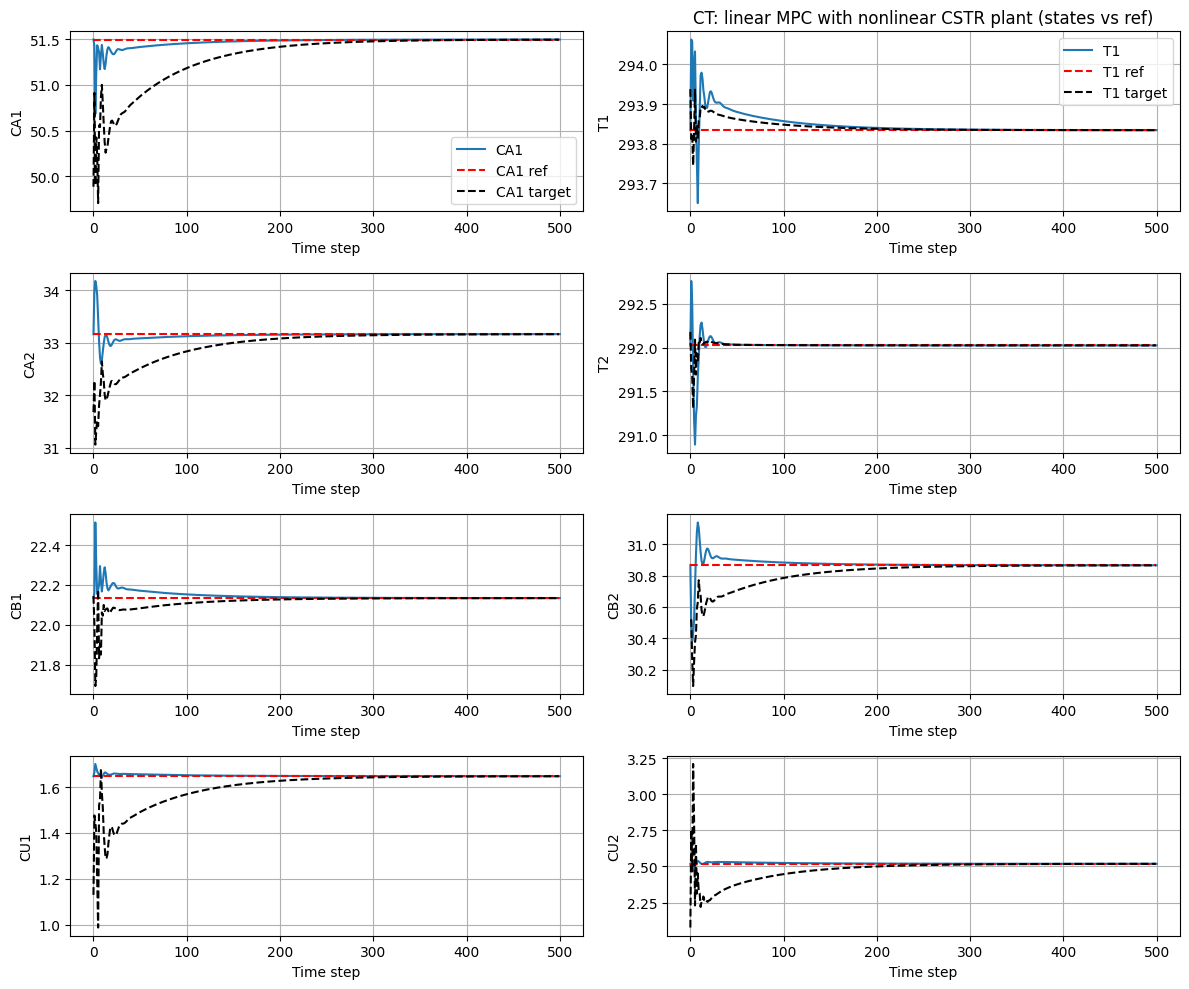

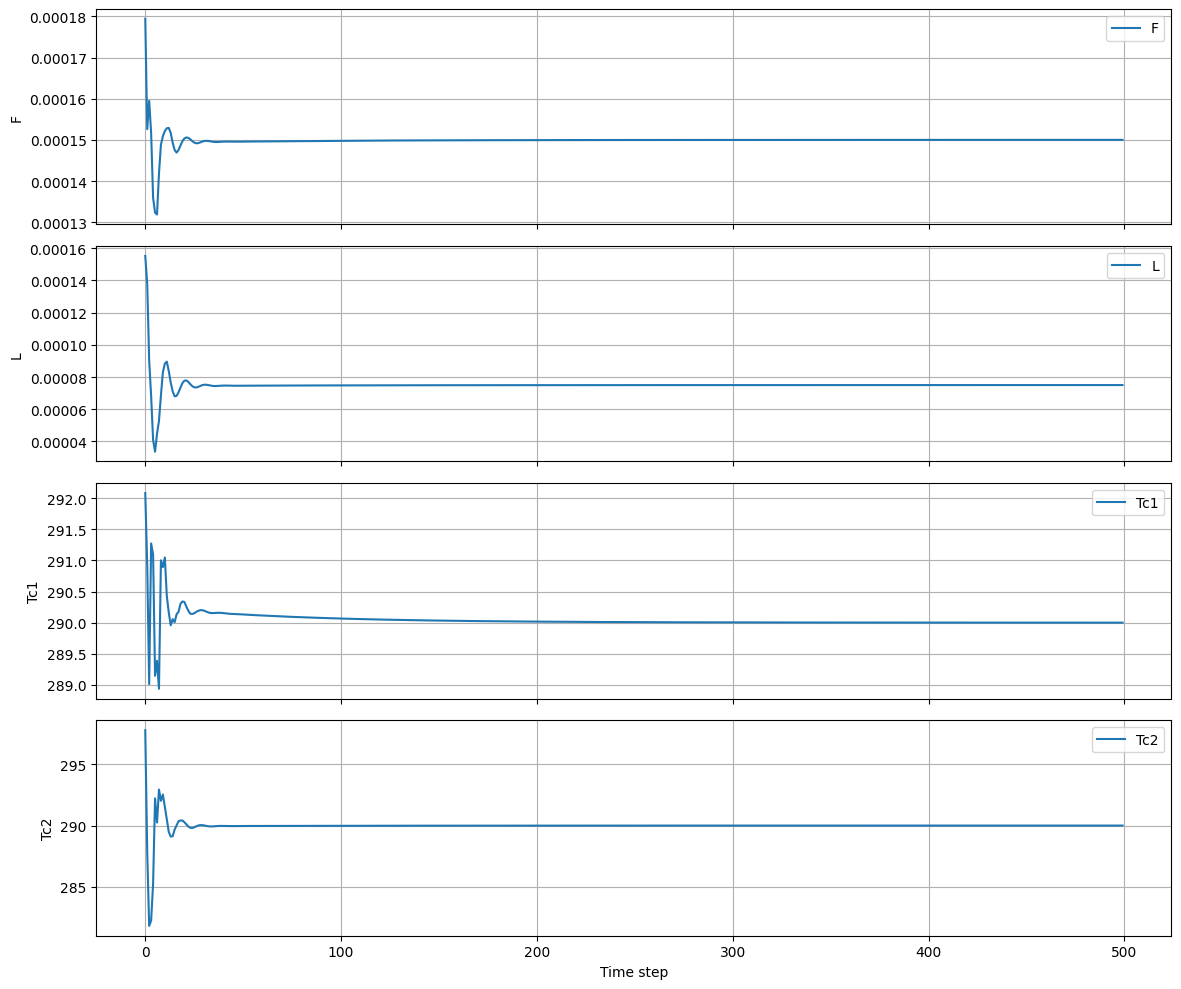

In [66]:
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
for k in range(sim_time):
    if reference is not None:
        y_ref_k = reference[:, k]
    else:
        y_ref_k = scaler.inverse_transform(loaded_setup['reference'][:, k].reshape(1, -1))[0]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")



# Plots saved to figures/ in non-scaled domain (8 states, 4 inputs)
ys_sim_ns = scaler.inverse_transform(ys_sim.T).T
zs_sim_ns = scaler.inverse_transform((C@zs_sim + z_sim[nz:]).T).T
z_sim_ns = scaler.inverse_transform((C@z_sim[:nz] + z_sim[nz:]).T).T
fig = plt.figure(figsize=(12, 10))
names = ['CA1','T1','CA2','T2','CB1','CB2','CU1','CU2']
n_steps = sim_time
for i in range(min(8, ny)):
    plt.subplot(4, 2, i+1)
    plt.plot(y_sim_ns[i, :], label=names[i] if i < len(names) else f'y{i}')
    if reference_ns is not None:
        plt.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
    plt.plot(zs_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    plt.xlabel('Time step')
    plt.ylabel(names[i] if i < len(names) else f'y{i}')
    plt.grid(True)
    if i in (0,1):
        plt.legend()
    if i == 1:
        plt.title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()
fig.savefig((figures_dir / 'CT_states.png').as_posix(), dpi=200)


fig_inputs, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
input_names = ['F', 'L', 'Tc1', 'Tc2']
for i in range(4):
    axs[i].plot(u_sim_ns[i, :], label=input_names[i])
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()


In [67]:
C@z_sim[:nz] + z_sim[nz:]

array([[ 0.61025943,  1.46025204,  1.41246818, ...,  1.46897322,
         1.4689734 ,  1.46897357],
       [-1.32479403, -1.15246866, -1.14735307, ..., -1.17564533,
        -1.1756455 , -1.17564566],
       [ 0.96448063,  1.90562468,  1.94269512, ...,  1.82096819,
         1.82096846,  1.82096872],
       ...,
       [-1.32923579, -1.60021189, -1.63469822, ..., -1.48615398,
        -1.4861543 , -1.48615461],
       [-0.56656933, -1.1915179 , -1.17753836, ..., -1.18982953,
        -1.18982958, -1.18982964],
       [-1.14670218, -1.39681715, -1.3911176 , ..., -1.38329007,
        -1.38329014, -1.38329021]])

In [68]:
scaler.inverse_transform((C@z_sim[:nz] + z_sim[nz:]).T).T

array([[ 39.64574971,  51.37763098,  50.71810229, ...,  51.49800373,
         51.4980061 ,  51.49800844],
       [292.64971523, 294.01829535, 294.05892254, ..., 293.83422999,
        293.83422867, 293.83422736],
       [ 25.73071497,  33.89544334,  34.21704132, ...,  33.16102093,
         33.16102327,  33.16102557],
       ...,
       [ 31.36393448,  30.50577241,  30.39655664, ...,  30.8669857 ,
         30.8669847 ,  30.8669837 ],
       [  4.345898  ,   1.63997887,   1.70050783, ...,   1.64728919,
          1.64728897,   1.64728874],
       [  3.56085927,   2.45889279,   2.48400409, ...,   2.51849097,
          2.51849065,   2.51849034]])